# Using Gurobi with CSDT for Multi-Target Regression

This notebook covers:
1. Setting up Gurobi for solving LP problems.
2. Implementing a custom decision tree regressor (CSDT) that uses Gurobi to solve sub-problems.
3. Training and evaluating the regressor on a multi-target regression dataset.

## Dataset
The dataset consists of:
- **Features**: ['EnrolledElectiveBefore', 'GradeAvgPrevElec', 'Grade', 'Major', 'Class', 'GradePerm']
- **Targets**: Multi-target regression outputs ['Course1', ..., 'Course7'].

Gurobi is used to determine optimal predictions for each target within each decision tree node.


## 1. Install and Configure Gurobi

### What is Gurobi?
Gurobi is an optimization solver that supports linear programming (LP), mixed-integer programming (MIP), and more.

### Installation Steps
1. **Install Gurobi**:
   - For Python: Run `pip install gurobipy`.
   - Ensure you have a valid Gurobi license. You can obtain an academic license for free from [Gurobi's website](https://www.gurobi.com/academia/academic-program-and-licenses/).

2. **Set Up License**:
   - Download the license file (`gurobi.lic`) and place it in your home directory or the default location suggested during installation.

3. **Verify Installation**:
   ```python
   import gurobipy as gp
   print(gp.gurobi.version())


In [ ]:

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import gurobipy as gp
from gurobipy import GRB
import os
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from IPython.display import display
from IPython.display import Image
import sys
base_folder = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(base_folder, "..")))
import csdt
from csdt import CSDT, split_criteria_with_methods
import csdt
SEED = 0
np.random.seed(SEED)

base_folder = os.getcwd()


## 2. Define Dataset and Problem Configuration

The dataset includes:
- **Features**: Six features related to academic performance.
- **Targets**: Seven regression outputs corresponding to course grades.

We also set the hyperparameters for the decision tree and optimization model.


In [2]:
# Define hyperparameters
ocdt_min_samples_split = 10
ocdt_min_samples_leaf = 5
ocdt_depth = 5
verbose = False
class_target_size = 7

# Define features and targets
features_list = ['EnrolledElectiveBefore', 'GradeAvgPrevElec', 'Grade', 'Major', 'Class', 'GradePerm']
target_list = [f'Course{id + 1}' for id in range(class_target_size)]

# Load dataset
df = pd.read_csv('../datasets/class_df_size_500_targets_7.csv')
features_df = df[features_list]
target_df = df[target_list]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)


## 3. Gurobi Optimization for Multi-Target Prediction

### Linear Programming (LP) Model
The goal is to minimize the sum of squared errors (SSE) while ensuring only one prediction is active per target.

### Constraints
1. **Sum of Binary Variables**: Only one prediction is allowed at a time (\(\sum z_j \leq 1\)).
2. **Prediction-Binary Relationship**: Each prediction is bound to its binary variable (\(y_j \leq M \cdot z_j\)).

### Objective Function
The objective is to minimize:
$$
SSE = \sum_{i=1}^N \sum_{j=1}^T (y_j - y_{ij})^2
$$


Here:
- \(N\): Number of data points in the node.
- \(T\): Number of targets.
- \(y_{ij}\): Actual value of the \(j^{th}\) target for the \(i^{th}\) data point.
- \(y_j\): Predicted value for the \(j^{th}\) target.


In [3]:
def formulate_and_solve_lp_class_data(y, x, lagrangian_multiplier=0, verbose=False):
    num_instances = y.shape[0]
    num_targets = y.shape[1]

    # Create model
    model = gp.Model("Minimize SSE")

    model.setParam("LogToConsole", 0)      
    model.setParam("OutputFlag", 0)      
    model.setParam("MIPGap", 1e-4)       

    # Create decision variables
    predictions = model.addVars(num_targets, lb=0, ub=100, name="y")
    binary_vars = model.addVars(num_targets, vtype=GRB.BINARY, name="z")

    # Create objective function
    sse = gp.quicksum(
        (predictions[j] - y[i][j]) * (predictions[j] - y[i][j])
        for i in range(num_instances) for j in range(num_targets)
    )

    # Add constraints
    model.addConstr(binary_vars.sum() <= 1, "one_prediction_constraint")
    for i in range(num_targets):
        model.addConstr(predictions[i] <= 110 * binary_vars[i], f"z_relationship_{i}")

    # Solve the problem
    model.setObjective(sse, GRB.MINIMIZE)
    model.optimize()

    if verbose:
        print("Optimal Solution:")
        for i in range(num_targets):
            print(f"Target {i + 1}: Prediction = {predictions[i].X}, Indicator = {binary_vars[i].X}")
        print("Objective (Sum of Squared Errors):", model.objVal)

    preds = np.array([predictions[i].X for i in range(num_targets)])
    return preds


## 4. Implement CSDT with Gurobi

We define:
- **Prediction Method**: Uses Gurobi to solve the LP problem.
- **Splitting Criterion**: Uses Mean Squared Error (MSE) to evaluate splits.


In [4]:
def calculate_mse(y, predictions):
    return mean_squared_error(y, predictions)

split_criteria = lambda y, x: split_criteria_with_methods(
    y, x, pred=formulate_and_solve_lp_class_data, split_criteria=calculate_mse
)
verbose = False
tree = CSDT(
    max_depth=ocdt_depth,
    min_samples_leaf=ocdt_min_samples_leaf,
    min_samples_split=ocdt_min_samples_split,
    split_criteria=split_criteria,
    verbose=verbose
)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)


Set parameter Username
Set parameter LicenseID to value 2593738
Academic license - for non-commercial use only - expires 2025-12-02


## 5. Evaluate the Model

We calculate and display the Mean Squared Error (MSE) for predictions made by the custom decision tree regressor.


In [5]:
ocdt_mse = mean_squared_error(y_test, y_pred)
print(f"CSDT MSE: {ocdt_mse}")


CSDT MSE: 1274.7338824285714


## 6. Visualize the Tree

The tree structure of the custom decision tree regressor is visualized and saved as an image.


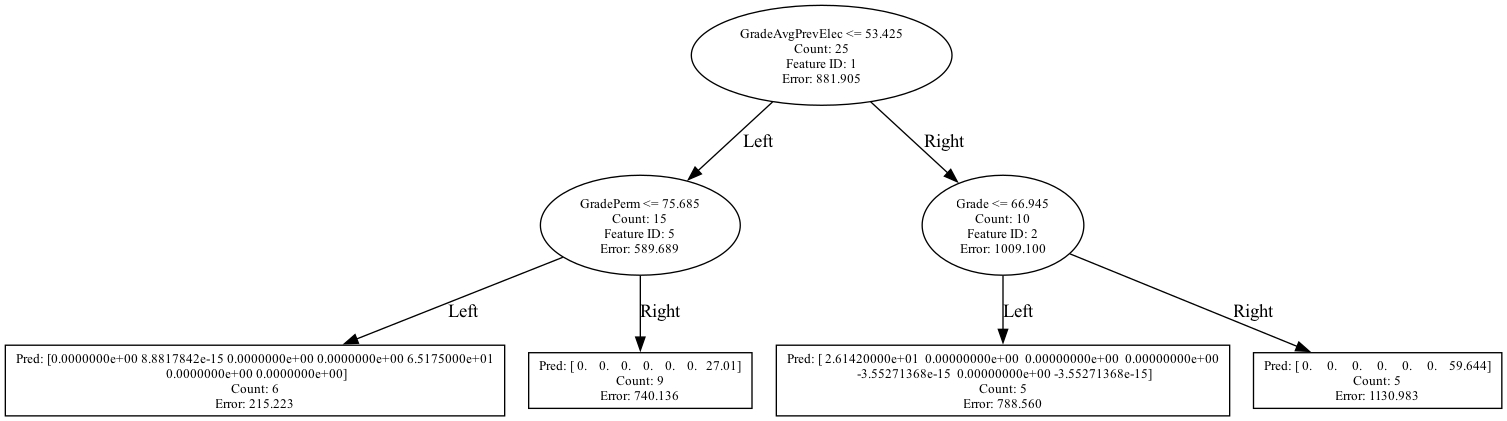

In [6]:
output_folder = "results"

os.makedirs(output_folder, exist_ok=True)

csdt_output_path = os.path.join(output_folder, 'class_ocdt')
dot = tree.draw_tree()
dot.render(csdt_output_path, format='png', view=True)
display(Image(filename=f"{csdt_output_path}.png"))


